## Import Libraries and Models

In [2]:
#manipulate paths
import os

#Audio utilities libraries
from scipy.io import wavfile as wav
import librosa
import sounddevice as sd
import IPython.display as ipd

#numpy
import numpy as np

#plot libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#tree load
import joblib

#keras for predictions
import keras
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array

#Models for image retrieval
from keras.applications import mobilenet_v2
from keras.preprocessing import image as kimage
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet

import cv2 as cv
import time

In [3]:
# Caricamento modello per il rilevamento di volti frontali
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
facenet = keras.models.load_model('FaceRecognition.h5')
recnet = keras.models.load_model('FFNN.h5')

In [5]:
# Caricamento modello MobileNetV2
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))
mobilenet_tree = joblib.load('MobileNet_tree.joblib')

/Users/raffaeleanselmo/anaconda3/envs/dsim/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kd_tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/raffaeleanselmo/anaconda3/envs/dsim/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.dist_metrics module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Demo

### Audio - Video

In [6]:
names = ['Lorenzo' ,'Raffaele', 'Unknown']

In [8]:
def process_frame(img):
    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    face = img
    
    faces = face_detector.detectMultiScale(gray, minSize=(250,250), minNeighbors=10)
     
    for (x,y,w,h) in faces:
        cv.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        face = img[y:y+h,x:x+w]

        img_pixels = cv.resize(face, (224, 224)) 
        img_pixels = img_to_array(img_pixels)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels = preprocess_input(img_pixels)
        y_prob = facenet.predict(img_pixels)
        y_pred = np.argmax(y_prob)
        y_prob = y_prob[0, y_pred]

        if(y_prob > 0.65):
            index = names[y_pred]
        else:
            index = "Unknown"

        cv.putText(img,
                  (str(index)+''+str(y_prob)),
                  (x+5,y-5),
                  cv.FONT_HERSHEY_SIMPLEX,
                  1,
                  (255,255,255),
                  2)
                    
    return img, faces

In [ ]:
cap = cv.VideoCapture(0)
duration = 2 # (qqqsecondi)
rec_rate = 44100
sent='Press "r" to register'
cv.startWindowThread()

while(True):
    color = (255,0,0)
    r, frame = cap.read()
    frame, faces = process_frame(frame)
    cv.putText(frame, sent, (15, 37), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)  
    cv.rectangle(frame, (1, 1), (850, 45), (255,255,255), 2)
    cv.imshow('Video', frame)
    
    if cv.waitKey(20) & 0xFF == ord('r'):
        prova = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)
        wav.write('test.wav', rate=rec_rate, data=(prova))
        rec_rate, rec = wav.read('test.wav')
        mfcc = np.mean(librosa.feature.mfcc(rec*1.0, sr=int(rec_rate), n_mfcc=20).T, axis=0)
        mfcc = mfcc.reshape(1,mfcc.shape[0])
        prob_audio = recnet.predict(mfcc)
        
        if max(prob_audio[0]) < 0.7: 
            pred_audio = 4 
        else:   
            pred_audio = np.argmax(prob_audio)

        if   pred_audio==0:
            res = "Raffaele ha detto acconsento"

        elif pred_audio == 1:
            res ="Raffaele ha detto rifiuto"

        elif pred_audio == 2:
            res ="Lorenzo ha detto acconsento"

        elif pred_audio == 3:
            res ="Lorenzo ha detto rifiuto"

        else:
            res ="Retry"

        sent = str(res)+''+str(prob_audio[0][pred_audio])

    if cv.waitKey(20) & 0xFF == ord("q"):
        break
        
cap.release()
cv.destroyAllWindows()

### Image Retrieval

In [5]:
#features extraction
def neural_features_mobilenet(img):
    x = kimage.img_to_array(img)
    x = preprocess_mobilenet(x)
    x = np.expand_dims(x, axis=0)
    f = mobilenet.predict(x)
    return f.flatten()

In [6]:
train, paths_2 = joblib.load("train_paths.joblib")

In [7]:
cap = cv.VideoCapture(0)
time.sleep(3)
result, img = cap.read()
cap.release()

faces = face_detector.detectMultiScale(img)
for (x,y,w,h) in faces:
    face = img[y:y+h,x:x+h,:]
#reshape dell'immagine
face=cv.resize(face, (224,224))

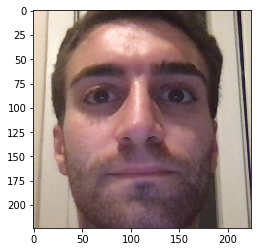

(<matplotlib.image.AxesImage at 0x1a64ea33d0>, None)

In [8]:
plt.imshow(face[:,:,-1::-1]), plt.show()

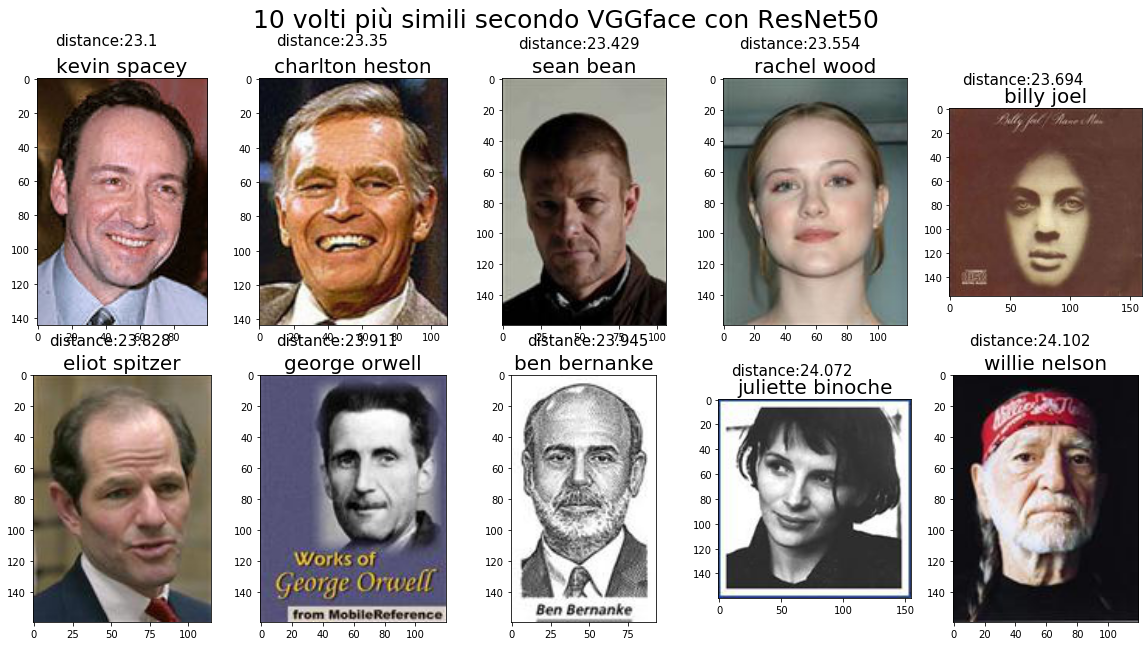

In [9]:
#estrazione delle neural_features_vggface50 dalla query
features = neural_features_mobilenet(face)
# Aggiunta dimensione per l'uso del KDTree
query_features = np.expand_dims(features, axis=0)
# interrogazione albero di ricerca
dist, ind = mobilenet_tree.query(query_features, k=10, dualtree = True)
# Mostrare l'elemento più simile a quello specificato nella query
fig = plt.figure(figsize=(20,10))
for i in range(10):
    sub = fig.add_subplot(2,5,i+1)
    sub.title.set_text(paths_2[ind[0][i]].split('/')[9])
    sub.text(10, -20, ("distance:" + str(round(dist[0][i],3))), fontsize=15)
    sub.title.set_size(20)
    fig.suptitle('10 volti più simili secondo VGGface con ResNet50',size=25)
    sub.imshow(kimage.load_img(paths_2[ind[0][i]]), interpolation='bilinear')